## Imports, Classes, and Constants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB

from sklearn.utils import shuffle
from sklearn import metrics

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

RANDOM_SEED = 42

class StemCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemCountVectorizer, self).build_analyzer()
        
        return lambda document: ([SnowballStemmer('english', ignore_stopwords=True).stem(word) for word in analyzer(document)])
    
mcu_subset = pd.read_csv("./data/mcu_subset.csv")

## Data Preprocessing

In [2]:
pd.DataFrame(mcu_subset['character'].value_counts())

,character
TONY STARK,1787
STEVE ROGERS,977
THOR,863
PETER PARKER,551
NATASHA ROMANOFF,498
PEPPER POTTS,441
BRUCE BANNER,379
NICK FURY,366
LOKI,327
SCOTT LANG,324


In [3]:
y = mcu_subset["character"].to_numpy().astype(str)
X = mcu_subset["line"].to_numpy().astype(str)

X, y = shuffle(X, y, random_state=RANDOM_SEED)

X[0:10], y[0:10]

(array(['We fight.', 'I thought you were out of one-liners.',
        'We’re not friends, and I don’t give a shit about your games! I’m going back to Asgard! ',
        'Well, look, I gotta change it every time you hack in, Tony.',
        'What about Ultron himself?',
        'Excuse me, did we come to your planet and blow stuff up? ',
        'Why?! Jarvis! Not my idea! What are we doing here? This is thousands of miles away, I gotta get Pepper, I gotta...',
        'Well, I think as the CEO I need to show up.',
        'When Thanos snapped his fingers, Earth become ground zero for a power surge of ridiculously cosmic proportions.  No one’s seen anything like it. Until two days ago.',
        'So, this all seems horrible. '], dtype='<U1388'),
 array(['STEVE ROGERS', 'TONY STARK', 'THOR', 'JAMES RHODES',
        'STEVE ROGERS', 'NICK FURY', 'TONY STARK', 'PEPPER POTTS',
        'ROCKET', 'BRUCE BANNER'], dtype='<U16'))

## Models

In [4]:
cross_validator = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
hyperparameter_cross_validator = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
score_method = "balanced_accuracy"

In [5]:
stem_count_vectorizer = StemCountVectorizer(binary=False)
tfidf_transformer = TfidfTransformer()
nb_classifier = MultinomialNB()

In [6]:
count_params = {'vect__stop_words': [None, stopwords.words('english')],
              'vect__ngram_range': [(1,1), (1,2)]}

tfidf_params = {'tfidf__use_idf': [True, False]}

nb_params = {'clf__alpha': [1, 1e-1, 1e-2, 1e-3],
             'clf__fit_prior': [True, False]}

In [7]:
pipe13 = Pipeline([('vect', stem_count_vectorizer),
                  ('tfidf', tfidf_transformer),
                  ('clf', nb_classifier)])

parameters13 = {**count_params, **tfidf_params, **nb_params}

model13 = GridSearchCV(pipe13, parameters13, cv=hyperparameter_cross_validator, scoring=score_method, n_jobs=-1, verbose=6)

## Nested CV Balanced Accuracy

In [8]:
models = {"model 13": model13}

cv_score_table = pd.DataFrame()

for name, model in models.items():
    results = cross_val_score(model, X, y, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=6)
    cv_score_table.insert(len(cv_score_table.columns), name, results, True)

cv_score_table.index.name = "fold"
cv_score_table.loc["mean"] = cv_score_table.mean()
cv_score_table.loc["std"] = cv_score_table.std()
cv_score_table.loc["max"] = cv_score_table.max()

cv_score_table

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 147.3min remaining: 220.9min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 147.8min remaining: 98.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 148.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 148.6min finished


,model 13
fold,
0,0.249301
1,0.248008
2,0.250329
3,0.233661
4,0.241926
mean,0.244645
std,0.006218
max,0.250329


## Confusion Matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 148.5min remaining: 222.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 149.0min remaining: 99.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 150.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 150.1min finished


Balanced Accuracy: 0.2446235150495225
Balanced Accuracy: 0.24462351504952248


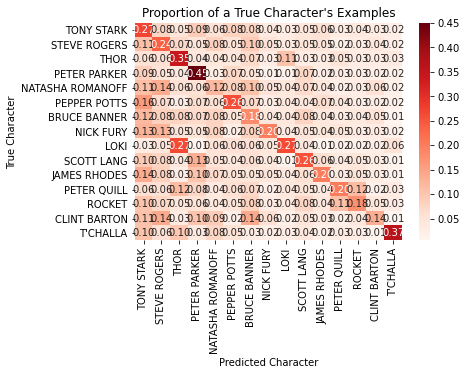

In [9]:
yhat = cross_val_predict(model13, X, y, cv=cross_validator, n_jobs=-1, verbose=6)

main_characters = mcu_subset['character'].value_counts().index.to_numpy()

conf_matrix = pd.DataFrame(metrics.confusion_matrix(y, yhat, labels=main_characters))
normalized_conf_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
normalized_conf_matrix.columns = pd.Series(main_characters, name="Predicted Character")
normalized_conf_matrix.index = pd.Series(main_characters, name="True Character")

plt.title("Proportion of a True Character's Examples")
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(normalized_conf_matrix)))

In [10]:
prediction_table = pd.DataFrame({"line": X, "true character": y, "predicted character": yhat})
print(X.shape)

#mcu_character_line_movie = pd.DataFrame({"character": mcu["character"], "line": mcu["line"], "movie": mcu["movie"]})

#prediction_table.line = prediction_table.line.astype(str)
#mcu_character_line_movie.line = mcu_character_line_movie.line.astype(str)

#prediction_table = prediction_table.merge(mcu_character_line_movie, left_on=["line", "true character"], right_on=['line', 'character'], how="left")

dump(prediction_table, "./front_end/production_predictions.joblib")

prediction_table.head()

(7681,)


,line,true character,predicted character
0,We fight.,STEVE ROGERS,THOR
1,I thought you were out of one-liners.,TONY STARK,STEVE ROGERS
2,"We’re not friends, and I don’t give a shit abo...",THOR,TONY STARK
3,"Well, look, I gotta change it every time you h...",JAMES RHODES,BRUCE BANNER
4,What about Ultron himself?,STEVE ROGERS,BRUCE BANNER


Above is a table containing the proportion of true examples for each prediction.  The diagonal cells represent the recall for each true label.  The average of our diagonal elements is our balanced accuracy (0.26 from our nested cross validation scoring table, as well as if you calculate it from the matrix).

## Learning Curve

In [11]:
def plot_learning_curve(estimator, title, X, y, axes=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, verbose=6)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")

    return

[learning_curve] Training set sizes: [ 614 1996 3379 4761 6144]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  25 | elapsed: 34.1min remaining: 818.4min
[Parallel(n_jobs=-1)]: Done   6 out of  25 | elapsed: 112.6min remaining: 356.7min
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed: 223.4min remaining: 284.3min
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed: 292.7min remaining: 164.6min
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed: 349.5min remaining: 66.6min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 399.6min finished


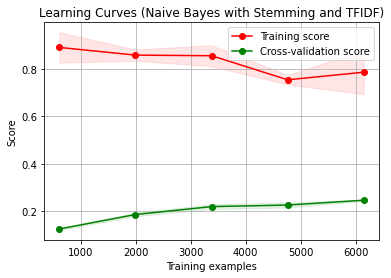

In [12]:
title = "Learning Curves (Naive Bayes with Stemming and TFIDF)"

plot_learning_curve(model13, title, X, y, cv=cross_validator)

## Error as a function of words

Text(0, 0.5, 'accuracy')

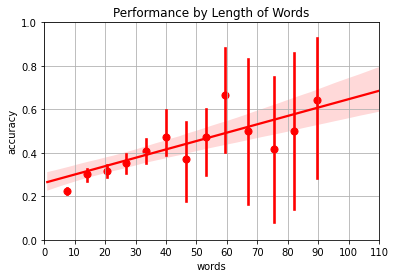

In [13]:
prediction_table['words'] = prediction_table['line'].str.split(" ").str.len()

prediction_table['correct prediction'] = prediction_table['true character'] == prediction_table['predicted character']
prediction_table['correct prediction'] = prediction_table['correct prediction'].astype('int64')

error_by_words = prediction_table.groupby(by='words').mean()
error_by_words.reset_index(drop=False, inplace=True)

plt.grid()
sns.regplot(x = error_by_words['words'].to_numpy(), 
            y = error_by_words['correct prediction'].to_numpy(), 
            color='r', robust = True, x_bins=15)

plt.xticks(np.arange(0,150,10))
plt.xlim(0,110)
plt.ylim(0,1)
plt.title('Performance by Length of Words')
plt.xlabel('words')
plt.ylabel('accuracy')

## Export Model

In [14]:
model13.fit(X,y)
model13.best_params_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 31.4min finished


{'clf__alpha': 0.01,
 'clf__fit_prior': False,
 'tfidf__use_idf': True,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [15]:
prod_model = Pipeline([('vect', StemCountVectorizer(binary=False, ngram_range=(1,2), stop_words=None)),
                  ('tfidf', TfidfTransformer(use_idf=True)),
                  ('clf', MultinomialNB(alpha=0.01, fit_prior=False))])

In [16]:
prod_model.fit(X,y)
dump(prod_model, './front_end/production_model.joblib')

['./front_end/production_model.joblib']